In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.theory.scattering_params import FofE_recursive
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
from scipy.linalg import svdvals
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator
from ATARI.sammy_interface.sammy_deriv import get_derivatives, find_interpolation_array, interpolate_derivatives

from ATARI.ModelData.particle import Particle, Neutron
from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.Bayes.bayes_update import Bayes, Bayes_extended

In [2]:
sammypath = '/Users/colefritsch/GitLab/Sammy/sammy/build/bin/sammy'
# sammypath = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'
assert(sammypath != '')

In [3]:
%matplotlib widget

# ATARI Sammy Interface

This user example details basic use of the ATARI/SAMMY interface module. 
The example given here shows how to do individual sammy runs using the NV or IQ solution scheme.
The AutoFit example will detail sammy interface with YW scheme that can be used for automatic evaluations or simultaneous data fitting.

In [4]:
### setup the reaction model and sample a resonance
Ta181 = Particle(Z=73, A=181, I=3.5, mass=180.94803, name='Ta181')
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [175,250], #[175,225],
                        ac = 0.8127,
                        target=Ta181,
                        projectile=Neutron,
                        l_max = 1)
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)
# Ta_pair.resonance_ladder = pd.DataFrame({'E':[197.0, 203.0], 'Gg':[64.0, 65.0], 'Gn1':[22.7266399211, 32.0], 'J_ID':[1.0, 1.0], 'Jpi':[3.0, 3.0], 'L':[0, 0]})
# Ta_pair.expand_ladder()
# Ta_pair.resonance_ladder[["varyE", "varyGg", "varyGn1"]] = 1
# Ta_pair.resonance_ladder[["varyE", "varyGg", "varyGn1"]] = 0
# Ta_pair.resonance_ladder[["varyGn1"]] = 1
# Ta_pair.resonance_ladder[["varyGg"]] = 1
# Ta_pair.resonance_ladder[["varyE"]] = 1

# setup experimental transmission model
# exp_model_T = Experimental_Model(energy_range=Ta_pair.energy_range, energy_grid=[199,201])
exp_model_T = Experimental_Model(energy_range=Ta_pair.energy_range)
print(exp_model_T.energy_range)

# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                        Print             = True,
                                        bayes             = True,
                                        derivatives       = False,
                                        bayes_scheme      = 'MW',
                                        iterations        = 1,
                                        use_least_squares = True,
                                        keep_runDIR       = True,
                                        sammy_runDIR      = 'sammy_runDIR_2')

template_creator.make_input_template('template_T.inp', Ta_pair, exp_model_T, rto)
exp_model_T.template = os.path.realpath('template_T.inp')

Ta_pair.resonance_ladder

[175, 250]


""


In [5]:
### Generate syndat from measurement models
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.control import Syndat_Model, syndatOPT


# synOPT = syndatOPT(sampleRES=False, calculate_covariance=True, explicit_covariance=True, )
synOPT = syndatOPT(sampleRES=True, calculate_covariance=True, explicit_covariance=True, )

synT = Syndat_Model(generative_experimental_model=exp_model_T, options=synOPT)

## need to test syndat covariance generation with different tof ordering !!!

synT.sample(Ta_pair, 
            sammyRTO=rto,
            num_samples=1)

datasample = synT.samples[0]
# data['exp'] = data['true']
datasample.pw_reduced.exp_unc = 1e5
# data['exp_unc'] = 0.00001
print(datasample.pw_reduced)

               tof           E      true       exp   exp_unc
0    195610.960868  175.016993  0.788459  0.714268  100000.0
1    195510.960853  175.199175  0.787909  0.786289  100000.0
2    195410.960890  175.381641  0.787311  0.803929  100000.0
3    195310.960959  175.564392  0.786662  0.741092  100000.0
4    195210.960846  175.747429  0.785961  0.778807  100000.0
..             ...         ...       ...       ...       ...
309  164710.960895  248.453308  0.571277  0.607068  100000.0
310  164610.960907  248.761496  0.612392  0.506519  100000.0
311  164510.960956  249.070258  0.639129  0.608062  100000.0
312  164410.960913  249.379595  0.658181  0.629720  100000.0
313  164310.960868  249.689508  0.672458  0.636925  100000.0

[314 rows x 5 columns]


In [6]:
# # Making a simple dataset
# data = pd.DataFrame({'tof': ['dunno'], 'E':[200.0], 'true':[0.6], 'exp':[0.6], 'exp_unc':[0.01]})

In [7]:
# print(vars(generative.model_parameters))
Ta_pair.resonance_ladder

,E,Gg,Gn1,J_ID,gg2,gn2,Jpi,L
0,178.578697,63.422289,-1.196099,1.0,31.711145,-25.206588,3.0,0.0
1,191.931026,61.570476,6.516599,1.0,30.785238,132.467794,3.0,0.0
2,201.416259,-67.804088,1.063837,1.0,-33.902044,21.110079,3.0,0.0
3,204.638528,-64.692799,-0.915906,1.0,-32.346399,-18.030970,3.0,0.0
4,208.715178,64.781978,-0.181528,1.0,32.390989,-3.538584,3.0,0.0
5,225.959061,-61.296350,-14.064610,1.0,-30.648175,-263.496401,3.0,0.0
6,235.757606,-59.553435,-18.055450,1.0,-29.776718,-331.159594,3.0,0.0
7,246.829508,-61.487551,35.309683,1.0,-30.743775,632.932170,3.0,0.0


In [8]:
init_par_uncert = 1.0

# Altering a bad ladder:
# res_ladder_bad = copy(Ta_pair.resonance_ladder)
res_ladder_bad = copy(datasample.par_true)
res_ladder_bad[["varyE", "varyGg", "varyGn1"]] = 1
res_ladder_bad["varyGg"] = 0
# print(res_ladder_bad)

# print(data.exp.values)
data = datasample.pw_reduced
# exp_data = pd.DataFrame({'E':data.E, 'exp_trans':data.exp, 'exp_unc':data.exp_unc})
exp_data = pd.DataFrame({'E':data.E, 'exp':data.exp, 'exp_unc':data.exp_unc})
exp_cov = datasample.covariance_data

sammyINP = sammy_classes.SammyInputData(Ta_pair,
                                        res_ladder_bad,
                                        os.path.realpath('template_T.inp'),
                                        exp_model_T,
                                        experimental_data = exp_data,
                                        energy_grid = exp_model_T.energy_grid,
                                        initial_parameter_uncertainty=init_par_uncert)

print('Prior')
print(res_ladder_bad[['E', 'Gg', 'Gn1']])
print()

rto_bayes = sammy_classes.SammyRunTimeOptions(rto.path_to_SAMMY_exe,
                                              derivatives = False,
                                              bayes_scheme = 'IQ')
sammy_out = sammy_functions.run_sammy(sammyINP, rto)
print('SAMMY Bayes:')
print(sammy_out.par_post[['E', 'Gg', 'Gn1']])
print()

sammy_out = get_derivatives(sammyINP, rto, u_or_p='u')
derivatives = sammy_out.derivatives
par_post, Mp = Bayes(sammy_out, Ta_pair, rto, init_par_uncert)
print('Custom Bayes:')
print(par_post[['E', 'Gg', 'Gn1']])
print()

Prior
            E         Gg        Gn1
0  178.578697  63.422289  -1.196099
1  191.931026  61.570476   6.516599
2  201.416259 -67.804088   1.063837
3  204.638528 -64.692799  -0.915906
4  208.715178  64.781978  -0.181528
5  225.959061 -61.296350 -14.064610
6  235.757606 -59.553435 -18.055450
7  246.829508 -61.487551  35.309683

SAMMY Bayes:
            E         Gg        Gn1
0  178.578697  63.422289  -1.196099
1  191.931026  61.570476   6.516599
2  201.416259 -67.804088   1.063837
3  204.638528 -64.692799  -0.915906
4  208.715178  64.781978  -0.181528
5  225.959061 -61.296350 -14.064610
6  235.757606 -59.553435 -18.055450
7  246.829508 -61.487551  35.309683

Custom Bayes:
            E         Gg        Gn1
0  178.554831  63.422289  -1.104266
1  191.933899  61.570476   7.063530
2  201.461905 -67.804088   1.056525
3  204.583120 -64.692799  -0.823111
4  207.930656  64.781978  -0.256430
5  225.973493 -61.296350 -13.638345
6  235.753543 -59.553435 -18.663301
7  246.835746 -61.487551  37.

# New Bayes:

In [9]:
# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                        Print             = True,
                                        bayes             = False,
                                        derivatives       = False,
                                        bayes_scheme      = 'MW',
                                        iterations        = 10,
                                        use_least_squares = True,#False,
                                        keep_runDIR       = True,
                                        sammy_runDIR      = 'sammy_runDIR_1')

template_creator.make_input_template('template_T.inp', Ta_pair, exp_model_T, rto)
exp_model_T.template = os.path.realpath('template_T.inp')

### Generate syndat from measurement models
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.control import Syndat_Model, syndatOPT


synOPT = syndatOPT(sampleRES=False, calculate_covariance=True, explicit_covariance=True, )

synT = Syndat_Model(generative_experimental_model=exp_model_T, options=synOPT)

## need to test syndat covariance generation with different tof ordering !!!

synT.sample(Ta_pair, 
            sammyRTO=rto,
            num_samples=1)

datasample = synT.samples[0]
# data['exp'] = data['true']
# datasample.pw_reduced.exp_unc = 1e7
datasample.covariance_data['diag_stat'] *= 1e7
# data['exp_unc'] = 0.00001
print(datasample.pw_reduced)

               tof           E      true       exp   exp_unc
0    195610.960868  175.016993  0.788459  0.813756  0.037197
1    195510.960853  175.199175  0.787909  0.719998  0.033433
2    195410.960890  175.381641  0.787311  0.879046  0.040820
3    195310.960959  175.564392  0.786662  0.727191  0.033211
4    195210.960846  175.747429  0.785961  0.758493  0.034283
..             ...         ...       ...       ...       ...
309  164710.960895  248.453308  0.571277  0.596784  0.027264
310  164610.960907  248.761496  0.612392  0.629937  0.029049
311  164510.960956  249.070258  0.639129  0.703065  0.031653
312  164410.960913  249.379595  0.658181  0.609944  0.027453
313  164310.960868  249.689508  0.672458  0.699771  0.031564

[314 rows x 5 columns]


In [10]:
init_par_uncert = 10.0
# WigLL = PTLL = True
WigLL = False
PTLL = True

# Altering a bad ladder:
# res_ladder_bad = copy(Ta_pair.resonance_ladder)
res_ladder_bad = copy(datasample.par_true)
res_ladder_bad[["varyE", "varyGg", "varyGn1"]] = 0
# res_ladder_bad["varyGg"] = 0
res_ladder_bad["varyGn1"] = 1

data = datasample.pw_reduced
# exp_data = pd.DataFrame({'E':data.E, 'exp_trans':data.exp, 'exp_unc':data.exp_unc})
exp_data = pd.DataFrame({'E':data.E, 'exp':data.exp, 'exp_unc':data.exp_unc})
exp_cov = datasample.covariance_data

sammyINP = sammy_classes.SammyInputData(Ta_pair,
                                        res_ladder_bad,
                                        os.path.realpath('template_T.inp'),
                                        exp_model_T,
                                        experimental_data = exp_data,
                                        experimental_covariance = exp_cov,
                                        energy_grid = exp_model_T.energy_grid,
                                        initial_parameter_uncertainty = init_par_uncert)

# print(sammyINP.resonance_ladder)

from time import time

print('Prior')
print(res_ladder_bad[['E', 'Gg', 'Gn1']])
print()

t0 = time()
par_post, Mp, chi2 = Bayes_extended(copy(sammyINP), rto, WigLL=WigLL, PTLL=PTLL)
print('Custom Bayes:')
print(par_post[['E', 'Gg', 'Gn1']])
print(f'Chi2 = {chi2}')
print(f'Runtime = {time()-t0} s')
print()

t0 = time()
rto_bayes = sammy_classes.SammyRunTimeOptions(rto.path_to_SAMMY_exe,
                                              bayes=True,
                                              derivatives = False,
                                              bayes_scheme = 'MW',
                                              iterations        = rto.iterations,
                                              use_least_squares = rto.use_least_squares,
                                              keep_runDIR       = True,
                                              sammy_runDIR      = 'sammy_runDIR_2')
sammy_out = sammy_functions.run_sammy(sammyINP, rto_bayes)
print('SAMMY Bayes:')
print(sammy_out.par_post[['E', 'Gg', 'Gn1']])
print(f'Chi2 = {sammy_out.chi2_post}')
print(f'Runtime = {time()-t0} s')
print()

# print(sammy_out.pw_post)

print('Prior', np.diff(np.sort(res_ladder_bad.E.to_numpy()))/9.0030)
print('Posterior', np.diff(np.sort(par_post.E.to_numpy()))/9.0030)
print(f'ideal = {np.sqrt(2/np.pi)}')

Prior
            E         Gg        Gn1
0  178.578697  63.422289  -1.196099
1  191.931026  61.570476   6.516599
2  201.416259 -67.804088   1.063837
3  204.638528 -64.692799  -0.915906
4  208.715178  64.781978  -0.181528
5  225.959061 -61.296350 -14.064610
6  235.757606 -59.553435 -18.055450
7  246.829508 -61.487551  35.309683



Custom Bayes:
            E         Gg           Gn1
0  178.578697  63.422289 -4.939083e-01
1  191.931026  61.570476 -2.256537e+00
2  201.416259 -67.804088  2.786978e-01
3  204.638528 -64.692799 -2.915938e-01
4  208.715178  64.781978 -1.375482e-07
5  225.959061 -61.296350  2.727719e+00
6  235.757606 -59.553435 -3.264806e+00
7  246.829508 -61.487551  3.003070e+00
Chi2 = 0.0007741079225598161
Runtime = 3.8057448863983154 s

SAMMY Bayes:
            E         Gg        Gn1
0  178.578697  63.422289  -1.196053
1  191.931026  61.570476   6.517733
2  201.416259 -67.804088   1.063930
3  204.638528 -64.692799  -0.916430
4  208.715178  64.781978  -0.181535
5  225.959061 -61.296350 -14.067082
6  235.757606 -59.553435 -18.050608
7  246.829508 -61.487551  35.303716
Chi2 = 6.106299e-05
Runtime = 0.25928807258605957 s

Prior [1.48309775 1.05356355 0.35791057 0.45281025 1.91534847 1.08836452
 1.22980131]
Posterior [1.48309775 1.05356359 0.35791059 0.45281017 1.91534855 1.08836443
 1.2298014 ]
ideal = 

In [11]:
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model
from ATARI.ModelData.particle import Particle, Neutron

sammypath = "/Users/colefritsch/GitLab/Sammy/sammy/build/bin/sammy"
# sammypath = "/home/wfritsc1/ATARI/SAMMY/sammy/build/bin/sammy"

bounds = (200.0, 250.0) # energy limits for window
ladder_bounds = [200.0,250.0] # energy limits for resonance ladder
num_sgs = 2 # number of spingroups
L = 0 # orbital angular momentum
Gnm_bar = (332.24347 + 452.56615) / 2
J_IDs = np.array([1.0, 2.0])
Jpis  = np.array([3.0, 4.0])
Gnms  = np.array([452.56615, 332.24347])
iterations = 5
max_steps = 15

init_par_uncert = 0.1
WigLL = PTLL = True
# WigLL = True
# PTLL = True

#%% Defining Particle Pair:

Ta181 = Particle(Z=73, A=181, I=3.5, mass=180.94803, name='Ta181')
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = ladder_bounds,
                        ac = 0.8127,
                        target=Ta181,
                        projectile=Neutron,
                        l_max = 1
)

# print quant number map up to l_max
Ta_pair.map_quantum_numbers(print_out=False)

# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615, #46.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347, #35.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

# Ta_pair.sample_resonance_ladder()
# Ta_pair.expand_ladder()

#%% Experiments:

cap1mm_exp_gen = Experimental_Model(title = "cap1",
                                reaction ="capture", 
                                energy_range = bounds,
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [bounds[1]], 
                                    "chw": [300],#[102.7],
                                    "dchw": [0.8]
                                })

trans1mm_exp_gen = Experimental_Model(title = "trans1",
                            reaction = "transmission", 
                            energy_range = bounds,
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),
                            channel_widths={
                                    "maxE": [bounds[1]],#[216.16, 613.02], 
                                    "chw": [100],#[204.7, 102.4],
                                    "dchw": [1.6, 1.6]
                                })

#%% RPIs:

from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT, Syndat_Control

sammy_rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                            Print        = True,
                                            bayes        = False,
                                            bayes_scheme = 'MW',
                                            keep_runDIR  = False,
                                            use_least_squares = False,
                                            iterations   = iterations,
                                            sammy_runDIR = 'sammy_runDIR_fudge')

template_creator.make_input_template('template_T.inp', Ta_pair, trans1mm_exp_gen, sammy_rto)
template_creator.make_input_template('template_Y.inp', Ta_pair, cap1mm_exp_gen, sammy_rto)

cap1mm_exp_gen.template = os.path.realpath('template_Y.inp')
trans1mm_exp_gen.template = os.path.realpath('template_T.inp')

### Measurement Models
cap1mm_meas_gen = Capture_Yield_RPI(trig_g     =  (1200000,   0),
                                    trig_bg    =  (100000,  0),
                                    trig_f     =  (120000,   0),
                                    trig_bf    =  (100000,  0))
cap1mm_meas_red = Capture_Yield_RPI(trig_g     =  (1200000,   0),
                                    trig_bg    =  (100000,  0),
                                    trig_f     =  (120000,   0),
                                    trig_bf    =  (100000,  0))

trans1mm_meas_gen = Transmission_RPI()
trans1mm_meas_red = Transmission_RPI()
trans1mm_meas_red.approximate_unknown_data(exp_model=trans1mm_exp_gen, smooth=False, check_trig=True)
trans1mm_meas_gen.approximate_unknown_data(exp_model=trans1mm_exp_gen, smooth=False, check_trig=True)
cap1mm_meas_red.approximate_unknown_data(exp_model=cap1mm_exp_gen, smooth=False, check_trig=True)
cap1mm_meas_gen.approximate_unknown_data(exp_model=cap1mm_exp_gen, smooth=False, check_trig=True)

experiments = [trans1mm_exp_gen, cap1mm_exp_gen]

### Syndat Models
options_cap1mm = syndatOPT(calculate_covariance=False, save_raw_data=True)

syndat_cap1mm = Syndat_Model(cap1mm_exp_gen,
                            cap1mm_meas_gen,
                            cap1mm_meas_red,
                            options = options_cap1mm,
                            title='cap1mm')

options_trans1mm = syndatOPT(calculate_covariance = True)
syndat_trans1mm = Syndat_Model(trans1mm_exp_gen,
                            trans1mm_meas_gen,
                            trans1mm_meas_red,
                            options = options_trans1mm,
                            title='trans1mm')

syndat_models = [syndat_trans1mm, syndat_cap1mm]
syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models= syndat_models
                        )

syndat.sample(sammy_rto, num_samples=1)

datasample = syndat.get_sample(0)
# data['exp'] = data['true']
# datasample.pw_reduced.exp_unc = 1e7
# datasample.covariance_data['diag_stat'] *= 1e7
# data['exp_unc'] = 0.00001
# print(datasample.pw_reduced)

In [12]:
# Altering a bad ladder:
# res_ladder_bad = copy(Ta_pair.resonance_ladder)
res_ladder_bad = copy(list(datasample.values())[0].par_true)
res_ladder_bad[["varyE", "varyGg", "varyGn1"]] = 1
res_ladder_bad["varyGg"] = 0
# res_ladder_bad["varyGn1"] = 1

datas = [dataset.pw_reduced for dataset in datasample.values()]
# exp_data = pd.DataFrame({'E':data.E, 'exp_trans':data.exp, 'exp_unc':data.exp_unc})
exp_data = [pd.DataFrame({'E':data.E, 'exp':data.exp, 'exp_unc':data.exp_unc}) for data in datas]
exp_cov = [dataset.covariance_data for dataset in datasample.values()]
datasets = [dataset.pw_reduced for dataset in datasample.values()]

sammyINP = sammy_classes.SammyInputDataYW(Ta_pair,
                                        res_ladder_bad,
                                        datasets,
                                        experiments,
                                        experimental_covariance = exp_cov,
                                        initial_parameter_uncertainty = init_par_uncert,
                                        iterations=5, step_threshold=1e-3, max_steps=5)

from time import time

print('Prior')
print(res_ladder_bad[['E', 'Gg', 'Gn1']])
print()

t0 = time()
par_post, Mp, chi2 = Bayes_extended(copy(sammyINP), sammy_rto, WigLL=WigLL, PTLL=PTLL)
print('Custom Bayes:')
print(par_post[['E', 'Gg', 'Gn1']])
print(f'Chi2 = {chi2} | {sum(chi2)}')
print(f'Runtime = {time()-t0} s')
print()

t0 = time()
rto_bayes = sammy_classes.SammyRunTimeOptions(sammy_rto.path_to_SAMMY_exe,
                                              bayes=True,
                                              derivatives = False,
                                              bayes_scheme = sammy_rto.bayes_scheme,
                                              iterations        = sammy_rto.iterations,
                                              use_least_squares = sammy_rto.use_least_squares,
                                              keep_runDIR       = True,
                                              sammy_runDIR      = 'sammy_runDIR_2')

sammy_out = sammy_functions.run_sammy_YW(sammyINP, rto_bayes)
print('SAMMY Bayes:')
print(sammy_out.par_post[['E', 'Gg', 'Gn1']])
print(f'Chi2 = {sammy_out.chi2_post} | {sum(sammy_out.chi2_post)}')
print(f'Runtime = {time()-t0} s')
print()

print(f'Chi2 Prior = {sammy_out.chi2} | {sum(sammy_out.chi2)}')
print()

# print(sammy_out.pw_post)

print('Prior', np.diff(np.sort(res_ladder_bad.E.to_numpy()))/9.0030)
print('Posterior', np.diff(np.sort(par_post.E.to_numpy()))/9.0030)
print(f'ideal = {np.sqrt(2/np.pi)}')

Prior
             E         Gg         Gn1
0   209.196287 -61.651993  115.797727
1   222.000989  64.953431   63.879275
2   230.315638  62.519904  -26.195423
3   241.412617 -68.709210  -34.504005
4   202.730973 -64.291760   -0.651822
5   213.782939 -63.215588   -4.325985
6   218.363942  65.348895   -2.770356
7   221.728736  60.561349   -7.629279
8   230.874550  63.165129  -23.656297
9   237.394535 -64.815087   33.974824
10  249.332093  63.085391   -6.021375



/Users/colefritsch/ENCORE/ATARI/ATARI/Bayes/bayes_update.py:352: UserWarning: Only least squares matches SAMMY. An approximation is used with prior covariances.
  warnings.warn('Only least squares matches SAMMY. An approximation is used with prior covariances.')


Custom Bayes:
             E         Gg         Gn1
0   209.192927 -61.651993  120.463426
1   221.983703  64.953431   64.548083
2   230.278672  62.519904  -21.993223
3   241.402797 -68.709210  -35.650006
4   202.782122 -64.291760   -0.683671
5   213.829272 -63.215588   -4.041608
6   218.336495  65.348895   -2.980078
7   221.682759  60.561349   -7.718768
8   230.868780  63.165129  -25.320006
9   237.393709 -64.815087   33.656920
10  249.317168  63.085391   -4.852558
Chi2 = [1214.1285545033477, 92.6721232579487] | 1306.8006777612964
Runtime = 4.498182773590088 s

	Converged step at 4 iterations
	Converged step at 4 iterations
	Converged step at 4 iterations
	Converged step at 3 iterations
	Converged step at 3 iterations
Maximum steps reached
SAMMY Bayes:
             E         Gg         Gn1
0   209.192436 -61.651993  120.539326
1   221.984850  64.953431   64.768533
2   230.256287  62.519904  -20.547859
3   241.402626 -68.709210  -35.655770
4   202.784161 -64.291760   -0.799428
5   213.8

In [13]:
raise RuntimeError()

RuntimeError: 

# Calculate Derivatives

In [ ]:
l = 0
Jpi = 3.0
gg20 = list(Ta_pair.spin_groups.values())[0]['<gg2>']
gn20 = list(Ta_pair.spin_groups.values())[0]['<gn2>']
Els = np.linspace(50, 10_000, 100)
Ggs = np.array([2*gg20])
Gns = np.linspace(100, 800, 5)
Ls = np.array([0])
Es = np.linspace(-10, 10, 100)
points, derivatives = find_interpolation_array(Ta_pair, exp_model_T, rto, Els, Ggs, Gns, Ls, Es, u_or_p='u')

interpolate_derivatives(points, derivatives, ...)

dP_dE_flat = dP_dE.reshape(num_energies,-1)
svs = svdvals(dP_dE_flat)
svs = np.sort(svs)[::-1]

figure(420)
clf()
plot(range(len(svs)), abs(svs), '.k')
yscale('log')
grid()
xlabel('Rank', fontsize=16)
ylabel('Singular Value', fontsize=16)
show()

/Users/colefritsch/ENCORE/ATARI/ATARI/theory/scattering_params.py:64: RuntimeWarning: invalid value encountered in sqrt
  k = (M/(M+m))*constant*np.sqrt(E)


[8.90642719e-01 8.91801612e-01 8.92972056e-01 8.94137749e-01
 8.95294455e-01 8.96437095e-01 8.97559689e-01 8.98655191e-01
 8.99715305e-01 9.00730251e-01 9.01688501e-01 9.02576448e-01
 9.03378014e-01 9.04074174e-01 9.04642377e-01 9.05055845e-01
 9.05282705e-01 9.05284952e-01 9.05017129e-01 9.04424738e-01
 9.03442247e-01 9.01990617e-01 8.99974216e-01 8.97276970e-01
 8.93757505e-01 8.89243098e-01 8.83522056e-01 8.76334192e-01
 8.67358943e-01 8.56200761e-01 8.42371313e-01 8.25268498e-01
 8.04152756e-01 7.78122629e-01 7.46094268e-01 7.06794809e-01
 6.58789462e-01 6.00579551e-01 5.30838603e-01 4.48898933e-01
 3.55652343e-01 2.55017312e-01 1.55794775e-01 7.24244622e-02
 2.03302008e-02 2.00823650e-03 2.68047000e-05 2.77636000e-05
 6.32789000e-05 9.75888000e-05 1.73269500e-04 3.06181800e-04
 4.93737600e-04 8.16853400e-04 1.51240780e-03 3.24783690e-03
 8.16045250e-03 1.86114613e-02 3.54174665e-02 5.77740244e-02
 8.41040447e-02 1.12768452e-01 1.42403783e-01 1.72005177e-01
 2.00892301e-01 2.286393

/Users/colefritsch/ENCORE/ATARI/ATARI/sammy_interface/sammy_deriv.py:157: RuntimeWarning: divide by zero encountered in divide
  dLT_dP = dT_dP / T[:,NA]


[4.87004059e-01 4.65740294e-01 4.43664863e-01 4.21053701e-01
 3.97954869e-01 3.74429005e-01 3.50549085e-01 3.26401476e-01
 3.02086836e-01 2.77720809e-01 2.53434386e-01 2.29373821e-01
 2.05699917e-01 1.82586549e-01 1.60218191e-01 1.38786299e-01
 1.18484348e-01 9.95014459e-02 8.20144856e-02 6.61790077e-02
 5.21191368e-02 3.99172577e-02 2.96044366e-02 2.11529197e-02
 1.44722954e-02 9.41093270e-03 5.76396850e-03 3.28826020e-03
 1.72331750e-03 8.15463300e-04 3.40860300e-04 1.22381500e-04
 3.63966000e-05 8.54890000e-06 1.48810000e-06 1.76100000e-07
 1.26000000e-08 5.00000000e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e-10 2.00000000e-10 3.00000000e-10
 5.00000000e-10 9.00000000e-10 1.60000000e-09 2.70000000e-09
 4.90000000e-09 8.70000000e-09 1.52000000e-08 2.67000000e-08
 4.66000000e-08 8.08000000e-08 1.39600000e-07 2.40300000e-07
 4.12600000e-07 7.067000

/Users/colefritsch/ENCORE/ATARI/ATARI/sammy_interface/sammy_deriv.py:157: RuntimeWarning: divide by zero encountered in divide
  dLT_dP = dT_dP / T[:,NA]


[2.47669630e-01 2.28734185e-01 2.09846634e-01 1.91299003e-01
 1.73181709e-01 1.55589650e-01 1.38619723e-01 1.22369121e-01
 1.06933241e-01 9.24032331e-02 7.88632099e-02 6.63871646e-02
 5.50357106e-02 4.48527917e-02 3.58625694e-02 2.80667509e-02
 2.14426673e-02 1.59424366e-02 1.14935329e-02 8.00102140e-03
 5.35158020e-03 3.41922900e-03 2.07240960e-03 1.18177170e-03
 6.27753300e-04 3.06920300e-04 1.36109700e-04 5.37745000e-05
 1.85108000e-05 5.39960000e-06 1.28860000e-06 2.40600000e-07
 3.32000000e-08 3.10000000e-09 2.00000000e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e-10
 2.00000000e-10 3.00000000e-10 5.00000000e-10 9.00000000e-10
 1.60000000e-09 2.80000000e-09 4.80000000e-09 8.40000000e-09
 1.44000000e-08 2.470000

/Users/colefritsch/ENCORE/ATARI/ATARI/sammy_interface/sammy_deriv.py:157: RuntimeWarning: divide by zero encountered in divide
  dLT_dP = dT_dP / T[:,NA]


[0.85908908 0.86021852 0.86136434 0.86252594 0.86370062 0.86488618
 0.86607989 0.86727847 0.86847804 0.86967403 0.87086106 0.87203286
 0.87318208 0.87430016 0.87537715 0.87640147 0.87735966 0.87823609
 0.87901256 0.87966792 0.88017747 0.88051239 0.88063887 0.88051716
 0.8801003  0.87933247 0.87814697 0.87646339 0.87418395 0.87118853
 0.86732774 0.86241323 0.85620378 0.84838503 0.83853925 0.82609968
 0.81028049 0.78996968 0.76356852 0.72876667 0.6822794  0.61970119
 0.53595814 0.42745885 0.29760621 0.16571822 0.06852816 0.03123155
 0.03128209 0.03550134 0.03932366 0.04397507 0.04984848 0.05909769
 0.07485408 0.10356417 0.14359256 0.1893516  0.23551669 0.27907217
 0.31876528 0.35432541 0.38594307 0.41399085 0.43888768 0.46103776
 0.48080631 0.49851289 0.51443254 0.52880005 0.54181523 0.553648
 0.5644431  0.57432408 0.58339671 0.59175189 0.59946798 0.6066128
 0.61324527 0.61941674 0.62517215 0.63055095 0.63558789 0.64031369
 0.64475559 0.64893781 0.65288195 0.65660732 0.66013127 0.6634693

In [ ]:
# l = 0
# Jpi = 3.0
# gg20 = list(Ta_pair.spin_groups.values())[0]['<gg2>']
# # gn20 = list(Ta_pair.spin_groups.values())[0]['<gn2>']
# num_energies = 100
# Es = np.linspace(1e-5, 10_000, 100)
# Gns = np.linspace(100, 800, 5)
# dP_dE = np.zeros((num_energies, len(Es), len(Gns), 3))
# for i, E0 in enumerate(Es):
#     print(f'El = {E0}')
#     for j, Gn0 in enumerate(Gns):
#         E = np.array([E0])
#         EB = (E[0]-10,E[0]+10)
#         Ta_pair.energy_range = EB
#         exp_model_T.energy_range = EB
#         E_grid = np.linspace(*EB, num_energies+2)[1:-1]
#         P = FofE_recursive(E, Ta_pair.ac, Ta_pair.M, Ta_pair.m, l)[1][l,:]
#         Gg  = 2*gg20 * np.ones((1,))
#         Gn  = Gn0 * np.ones((1,))
#         gg2 = gg20 * np.ones((1,))
#         gn2 = Gn0/(2*P) * np.ones((1,))
#         Ta_pair.resonance_ladder = pd.DataFrame([E, Gg, Gn, [1], gg2, gn2, [Jpi], [l]],
#                                             index=['E', 'Gg', 'Gn1',  'J_ID', 'gg2', 'gn2', 'Jpi', 'L',]).T
#         exp_model_T.energy_grid = E_grid
#         sammyINP = sammy_classes.SammyInputData(
#             Ta_pair,
#             Ta_pair.resonance_ladder,
#             os.path.realpath('template_T.inp'),
#             exp_model_T,
#             energy_grid=exp_model_T.energy_grid
#         )
#         sammy_out = get_derivatives(sammyINP, rto)
#         dP_dE[:,i,j,:] = sammy_out.derivatives

# dP_dE_flat = dP_dE.reshape(num_energies,-1)
# svs = svdvals(dP_dE_flat)
# svs = np.sort(svs)[::-1]

# figure(420)
# clf()
# plot(range(len(svs)), abs(svs), '.k')
# yscale('log')
# grid()
# xlabel('Rank', fontsize=16)
# ylabel('Singular Value', fontsize=16)
# show()

In [ ]:
dP_dE_flat = dP_dE.reshape(num_energies,-1)
svs = svdvals(dP_dE_flat)
svs = np.sort(svs)[::-1]

figure(421)
clf()
plot(range(len(svs)), abs(svs), '.k')
yscale('log')
grid()
xlabel('Rank', fontsize=16)
ylabel('Singular Value', fontsize=16)
show()

NameError: name 'dP_dE' is not defined

In [ ]:
# l = 0
# Jpi = 3.0
# gg20 = 1.0
# gn20 = 1.0
# EB = (5,500)
# E = np.arange(*EB, 10)
# N_res = len(E)

# Ta_pair.energy_range = EB
# exp_model_T.energy_range = EB

# E_grid = np.linspace(*EB, 10_000)
# P = FofE_recursive(E, Ta_pair.ac, Ta_pair.M, Ta_pair.m, l)[1][l,:]
# Gg = 2*gg20 * np.ones((N_res,))
# Gn = 2*P*gn20 * np.ones((N_res,))
# gg2 = gg20 * np.ones((N_res,))
# gn2 = gn20 * np.ones((N_res,))
# Ta_pair.resonance_ladder = pd.DataFrame([E, Gg, Gn, [1]*N_res, gg2, gn2, [Jpi]*N_res, [l]*N_res],
#                                      index=['E', 'Gg', 'Gn1',  'J_ID', 'gg2', 'gn2', 'Jpi', 'L',]).T
# exp_model_T.energy_grid = E_grid
# sammyINP = sammy_classes.SammyInputData(
#     Ta_pair,
#     Ta_pair.resonance_ladder,
#     os.path.realpath('template_T.inp'),
#     exp_model_T,
#     energy_grid=exp_model_T.energy_grid
# )
# sammy_out = get_derivatives(sammyINP, rto)
# print(sammy_out.derivatives)

In [ ]:
raise RuntimeError('STOP!!!')

RuntimeError: STOP!!!

In [ ]:
### Option to read in idc or you can just pass to sammy a filepath


# def read_idc(filepath):
#     data = {
#         'J': {},
#         'C': None,
#         'stat': None
#     }

#     with open(filepath, 'r') as f:
#         num_params = None
#         in_partial_derivatives = False
#         in_uncertainties = False
#         in_correlations = False
#         for line in f.readlines():
            
#             if line.lower().startswith("nu"):
#                 num_params = int(line.split()[-1])
            
#             elif line.lower().startswith("free-forma"):
#                 in_partial_derivatives = True

#             elif line.lower().startswith("uncertaint"):
#                 in_partial_derivatives = False
#                 in_uncertainties = True
            
#             elif line.lower().startswith("correlatio"):
#                 in_uncertainties = False
#                 in_correlations = True

#             elif in_partial_derivatives:
#                 splitline = line.split()
#                 E = float(splitline[0])
#                 stat_unc = float(splitline[1])
#                 derivatives = [float(x) for x in splitline[2:]]
#                 data['J'][E] = {'stat_unc': stat_unc, 'derivatives': derivatives}
                
#             elif in_uncertainties:
#                 uncertainties = [float(e) for e in line.split()]
#                 data['C'] = np.diag(uncertainties)

#             elif in_correlations:
#                 assert isinstance(num_params, int)
#                 correlations = []
#                 for _ in range(num_params):
#                     line = f.readline().strip().split()
#                     correlations.append([float(x) for x in line])

#     data['stat'] = None  # You need to fill in the logic for reading the 'stat' data

#     return data

# Usage
# filepath = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-1mm.idc'
# read_data = read_idc(filepath)

In [ ]:
print(datasample.covariance_data.keys())

dict_keys(['CovT', 'Cov_sys', 'Jac_sys', 'diag_stat'])


In [ ]:
datasample.covariance_data['CovT']

E,200.200037,200.422933,200.646202,200.869845,201.093861,201.318253,201.543020,201.768164,201.993685,202.219584,...,246.920925,247.226266,247.532173,247.838648,248.145693,248.453308,248.761496,249.070258,249.379595,249.689508
200.200037,0.001255,0.000393,0.000389,0.000373,0.000363,0.000392,0.000392,0.000379,0.000396,0.000369,...,0.000133,0.000106,0.000101,0.000062,0.000061,0.000065,0.000093,0.000122,0.000149,0.000212
200.422933,0.000393,0.001425,0.000407,0.000391,0.000380,0.000411,0.000410,0.000397,0.000415,0.000387,...,0.000139,0.000111,0.000106,0.000065,0.000064,0.000068,0.000097,0.000128,0.000156,0.000222
200.646202,0.000389,0.000407,0.001368,0.000386,0.000376,0.000406,0.000406,0.000392,0.000410,0.000382,...,0.000137,0.000110,0.000105,0.000064,0.000063,0.000067,0.000096,0.000126,0.000154,0.000220
200.869845,0.000373,0.000391,0.000386,0.001214,0.000361,0.000390,0.000389,0.000376,0.000393,0.000367,...,0.000132,0.000106,0.000100,0.000061,0.000060,0.000064,0.000092,0.000121,0.000148,0.000211
201.093861,0.000363,0.000380,0.000376,0.000361,0.001202,0.000380,0.000379,0.000366,0.000383,0.000357,...,0.000128,0.000103,0.000098,0.000060,0.000059,0.000062,0.000090,0.000118,0.000144,0.000205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248.453308,0.000065,0.000068,0.000067,0.000064,0.000062,0.000067,0.000067,0.000065,0.000068,0.000063,...,0.000023,0.000018,0.000017,0.000011,0.000010,0.000084,0.000016,0.000021,0.000026,0.000037
248.761496,0.000093,0.000097,0.000096,0.000092,0.000090,0.000097,0.000097,0.000094,0.000098,0.000091,...,0.000033,0.000026,0.000025,0.000015,0.000015,0.000016,0.000136,0.000030,0.000037,0.000053
249.070258,0.000122,0.000128,0.000126,0.000121,0.000118,0.000128,0.000127,0.000123,0.000129,0.000120,...,0.000043,0.000035,0.000033,0.000020,0.000020,0.000021,0.000030,0.000201,0.000048,0.000069
249.379595,0.000149,0.000156,0.000154,0.000148,0.000144,0.000155,0.000155,0.000150,0.000157,0.000146,...,0.000053,0.000042,0.000040,0.000024,0.000024,0.000026,0.000037,0.000048,0.000273,0.000084


In [ ]:
# ### decomposed covariance test
# stat = copy(datasample.covariance_data["diag_stat"])
# CT = copy(datasample.covariance_data['CovT'])
# J = copy(datasample.covariance_data['Jac_sys'])
# C = copy(datasample.covariance_data['Cov_sys'])
# # C = np.diag(np.diag(C))
# test = J.T@C@J
# test.index.name = None
# assert(np.max(abs((np.diag(stat.var_stat) + test) - CT)) == 0.0)

# Fit the data with sammy

In [ ]:
rto.bayes=True
rto.get_ECSCM = True
rto.ECSCM_rxn = 'transmission'

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    Ta_pair.resonance_ladder,
    os.path.realpath('template_T.inp'),
    exp_model_T,
    # energy_grid=exp_model_T.energy_grid
    experimental_data=data,
    experimental_covariance = datasample.covariance_data
)

sammyINP.initial_parameter_uncertainty=10

# std = 0.01
# data.exp = np.random.default_rng().normal(data.true, std)
# data.exp_unc = std

sammyINP.experimental_data = data
sammyINP.resonance_ladder["varyE"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGg"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGn1"] = np.ones(len(Ta_pair.resonance_ladder))

sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
print(sammyOUT2.chi2_post)
print(sammyOUT2.chi2n_post)

21351.5
112.971


BACKGround functions
EXPON 0 0 582.77685 33.822441 0.0514968 0.0046811 

NORMALIZATION AND BACKGROUND ARE NEXT
1.0000000        0.0                                         3
0.0384200

!! when fitting background or normalization, the output lst has an additional column I need to be robust to.

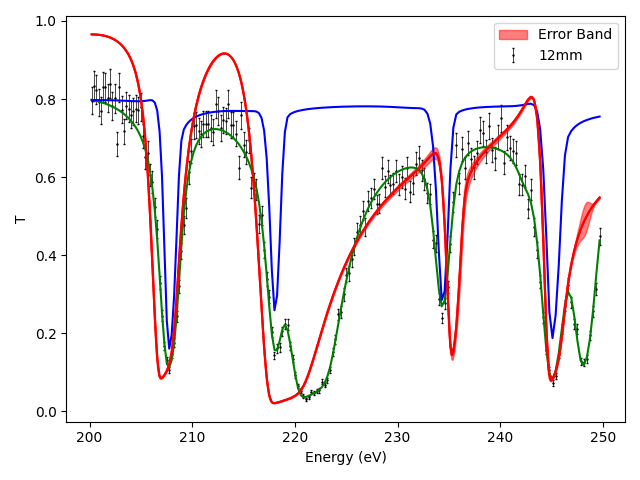

In [ ]:

### Plot 
figure()

errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

plot(data.E, data.true, 'g')

plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans, 'b')
plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_trans_bayes, 'r')

# plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_xs, 'b')
# plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_xs_bayes, 'r')
# # plot(sammyOUT_old.est_df.E, sammyOUT_old.est_df.theo, 'b')
# # sammyOUT_old = copy(sammyOUT2)

x = sammyOUT2.est_df.E
y = sammyOUT2.est_df.theo
y_err=  sammyOUT2.est_df.theo_unc #
# y_err = np.sqrt(np.diag(sammyOUT2.ECSCM))
fill_between(x, y - y_err, y + y_err, color='r', alpha=0.5, label='Error Band')
plot(x, y, 'r')

ylabel("T")

# xlim([200,225])
# ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()


# figure()
# imshow(sammyOUT2.ECSCM)
# colorbar()

In [ ]:
ladder = copy(sammyOUT2.par_post)
print(ladder)
Ta_pair.spin_groups

            E          Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0  210.215481    0.000009    0.000010    1.0     1.0      1.0   1.0
1  227.827455  340.521908   14.015338    1.0     1.0      1.0   1.0
2  238.459954 -522.547919  571.377856    1.0     1.0      1.0   1.0
3  243.898358    0.000009    0.000010    1.0     1.0      1.0   1.0
4  246.069748  701.937209    0.000010    1.0     1.0      1.0   1.0


{3.0: {'Jpi': 3.0,
  'J_ID': 1,
  '<D>': 8.79,
  '<gn2>': 465,
  'n_dof': 1,
  '<gg2>': 350,
  'g_dof': 1000,
  'quantiles': {'D01': 0.9943384234177864,
   'D99': 21.284662911191237,
   'gn01': 0.07304585392801136,
   'gn99': 3085.2269194748646,
   'gg01': 314.61935642536463,
   'gg99': 387.43914802327606,
   'gt01': 314.69240227929265,
   'gt99': 3472.666067498141},
  'chs': 1,
  'Ls': [0]}}

: 

In [ ]:
from ATARI.utils.atario import expand_sammy_ladder_2_atari

expand_sammy_ladder_2_atari(Ta_pair, ladder)
ladder

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID,gg2,gn2,Jpi,L
0,210.215481,0.000009,0.000010,1.0,1.0,1.0,1.0,0.000005,0.000195,3.0,0.0
1,227.827455,340.521908,14.015338,1.0,1.0,1.0,1.0,170.260954,261.494416,3.0,0.0
2,238.459954,-522.547919,571.377856,1.0,1.0,1.0,1.0,-261.273959,10420.236167,3.0,0.0
3,243.898358,0.000009,0.000010,1.0,1.0,1.0,1.0,0.000005,0.000180,3.0,0.0
4,246.069748,701.937209,0.000010,1.0,1.0,1.0,1.0,350.968605,0.000185,3.0,0.0


In [ ]:
# samples = 100

# cov_true = np.zeros([len(sammyOUT2.pw),len(sammyOUT2.pw)])
# cov_est = np.zeros([len(sammyOUT2.est_df),len(sammyOUT2.est_df)])

# for i in range(samples):
#     # synT.run(sammyOUT.pw)
#     data.exp = np.random.default_rng().normal(synT.data.true, std)
#     data.exp_unc = std
#     sammyINP.experimental_data = synT.data
#     sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#     residual = np.atleast_2d(sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#     cov_true += residual.T@residual
#     cov_est += sammyOUT2.ECSCM
#     # true.append(cov_true)
#     # est.append(cov_est)

In [ ]:
# iest = 0
# fig, axes = subplots(1,2, figsize=(10,4))
# # im1 = axes[0].imshow(np.log10(cov_true/(samples)))
# # im2 = axes[1].imshow(np.log10(cov_est/(samples-1)))
# im1 = axes[0].pcolormesh(cov_true/(samples), clim=(-1e-5, 8e-5))
# im2 = axes[1].pcolormesh(cov_est/(samples-1), clim=(-1e-5, 8e-5))
# axes[0].set_title("empirical")

# axes[1].set_title("estimated")
# # for ax in axes:
# colorbar(im1)

# colorbar(im2)

# print("Empirical Fnorm")
# print(np.linalg.norm(cov_true/(samples), ord='fro'))
# print("Estimated Fnorm")
# print(np.linalg.norm(cov_est/(samples-1), ord='fro'))

In [ ]:
# ### Plot 
# figure()

# # errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
# #                                         fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

# # plot(synT.data.E, synT.data.true, 'g')
# plot(synT.data.E, np.sqrt(np.diag(cov_true/samples)), label="empirical")
# plot(x, np.sqrt(np.diag(cov_est/(samples-1))), label="mean estimated")


# xlim([200,225])
# # ylim([-0.1,1.1])
# legend()

# xlabel('Energy (eV)')
# tight_layout()

In [ ]:
# # result_dict = {}
# # stds = [0.1, 0.01, 0.001, 0.0001]
# stds = [0.00001, 0.05]

# for istd in stds:
#     samples = 1000
#     cov_true = np.zeros([len(sammyOUT2.pw), len(sammyOUT2.pw)])
#     cov_est = np.zeros([len(sammyOUT2.est_df), len(sammyOUT2.est_df)])
#     for i in range(samples):
#         # synT.run(sammyOUT.pw)
#         synT.data.exp = np.random.default_rng().normal(synT.data.true, istd)
#         synT.data.exp_unc = istd
#         sammyINP.experimental_data = synT.data
#         sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#         residual = np.atleast_2d(
#             sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#         cov_true += residual.T@residual
#         cov_est += sammyOUT2.ECSCM
        
#     result_dict[istd] = [cov_true, cov_est]

In [ ]:
# stds = [1.0, 0.1, 0.05, 0.01, 0.001, 0.0001]
# true= []
# est = []

# for istd in stds:
#     res = result_dict[istd]
#     cov_true = res[0]
#     cov_est = res[1]
#     print(istd)
#     # print("Empirical Fnorm: ", np.linalg.norm(cov_true/(samples), ord='fro'))
#     # print("Estimated Fnorm: ", np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     # true.append(np.linalg.norm(cov_true/(samples), ord='fro'))
#     # est.append(np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     print("Empirical Fnorm: ", np.sum(np.diag(cov_true)**2/(samples)))
#     print("Estimated Fnorm: ", np.sum(np.diag(cov_est)**2/(samples-1)))
#     true.append(np.sum(np.diag(cov_true)**2/(samples)))
#     est.append(np.sum(np.diag(cov_est)**2/(samples-1)))

In [ ]:
# figure()
# plot(stds, true, '.', label='Empirical')
# plot(stds, est, '.r', label='Estimate')
# xscale("log")
# yscale("log")
# legend()
# # ylabel("Noise Level")
# xlabel("Noise Level")